<a href="https://colab.research.google.com/github/ChayHuiXiang/TF_ACDoom/blob/main/doom_animalcrossing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Downloading & Pre-processing Datasets**

In [ ]:
#imports
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
#downloading datasets from kaggle
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download andrewmvd/doom-crossing

 99% 983M/997M [00:10<00:00, 135MB/s]
100% 997M/997M [00:11<00:00, 94.4MB/s]


In [ ]:
#unzip downloaded zip file
!unzip doom-crossing.zip


Archive:  doom-crossing.zip
  inflating: animal_crossing/0177myxmpiq41.jpg  
  inflating: animal_crossing/05tmnohw0qn41.png  
  inflating: animal_crossing/06wprmd2m7u41.jpg  
  inflating: animal_crossing/07nqetuqw9w41.jpg  
  inflating: animal_crossing/07xjd27c8uy41.jpg  
  inflating: animal_crossing/086tektpmp051.jpg  
  inflating: animal_crossing/0czcmw8rmsz41.jpg  
  inflating: animal_crossing/0d95wo29cl051.jpg  
  inflating: animal_crossing/0f348gu5nuk41.jpg  
  inflating: animal_crossing/0gdakfpl6bh41.jpg  
  inflating: animal_crossing/0htu1r0l35y41.jpg  
  inflating: animal_crossing/0iycgvopjqp41.jpg  
  inflating: animal_crossing/0jun1e5etxu41.jpg  
  inflating: animal_crossing/0k85pi0eqd151.jpg  
  inflating: animal_crossing/0lln1q0ag1r41.jpg  
  inflating: animal_crossing/0mzs9f0wb8z41.jpg  
  inflating: animal_crossing/0ozodkocirw41.jpg  
  inflating: animal_crossing/0wovk4f2v0h41.jpg  
  inflating: animal_crossing/0yotitpwxht41.jpg  
  inflating: animal_crossing/10pvsht7efq4

In [ ]:
#Remove existing datasets folder (if any)
!rm -rf datasets

In [ ]:
#Create new datasets folder and move all images to folder
!mkdir datasets
!mv doom datasets
!mv animal_crossing datasets

In [ ]:
#Set Batch Size & Image Size according to official documentation
BATCH_SIZE = 32
IMG_SIZE = (160,160)

In [ ]:
#getting training dataset & validation dataset
train_dataset = image_dataset_from_directory('./datasets',validation_split=0.3,subset="training",seed=123,batch_size=BATCH_SIZE,image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory('./datasets',validation_split=0.3,subset="validation",seed=123,image_size=IMG_SIZE,batch_size=BATCH_SIZE)

Found 1597 files belonging to 2 classes.
Using 1118 files for training.
Found 1597 files belonging to 2 classes.
Using 479 files for validation.


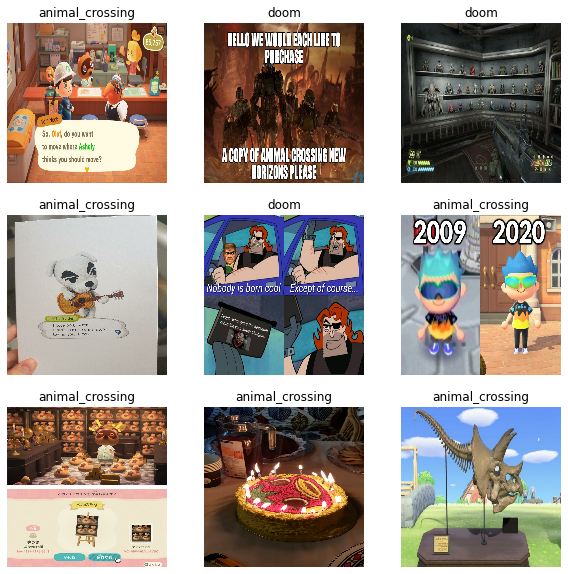

In [ ]:
#show first nine images and labels from training set
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#splitting validation dataset into test and validation batches, from tensorflow docs
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
#displaying the number of test batches and validation batches
test_datano = int(tf.data.experimental.cardinality(test_dataset))
validation_datano = int(tf.data.experimental.cardinality(validation_dataset))

print('No. of test batches:',test_datano)
print('No. of validation batches:',validation_datano)

No. of test batches: 3
No. of validation batches: 12


In [ ]:
#Use buffered prefetching to load images from disk without having I/O become blocking**
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
#data augmentation to increase diversity of training set

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

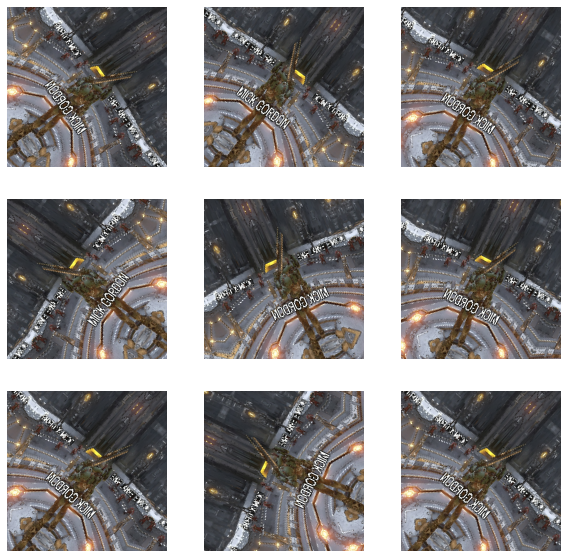

In [ ]:
#looking at augmented images
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
#Rescale pixel values from [0,255] to [-1,1]
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

# **Creation of Base Model**

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
#converting 160x160x3 image into 5x5x1280 block of features
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


# **Feature Extraction**

In [ ]:
#freezing the base model to prevent the layers from being updated during training
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
#applying pooling layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
#prediction layer
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1280)
(32, 1)


In [ ]:
#sending the data into the model
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
#compiling the model that we have
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
#summary of compiled model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [ ]:
#Pass the training dataset into the model 10 times
initial_epochs=10
loss0, accuracy0 = model.evaluate(validation_dataset)

12/12 [==============================] - 16s 498ms/step - loss: 0.8993 - accuracy: 0.4282


In [ ]:
#printing initial loss and accuracy
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.90
initial accuracy: 0.43


In [ ]:
#training the model
history = model.fit(train_dataset,epochs=initial_epochs,validation_data=validation_dataset)

Epoch 1/10
35/35 [==============================] - 53s 1s/step - loss: 0.9151 - accuracy: 0.4436 - val_loss: 0.8204 - val_accuracy: 0.4648
Epoch 2/10
35/35 [==============================] - 50s 1s/step - loss: 0.8233 - accuracy: 0.5116 - val_loss: 0.7527 - val_accuracy: 0.5170
Epoch 3/10
35/35 [==============================] - 50s 1s/step - loss: 0.7677 - accuracy: 0.5295 - val_loss: 0.6928 - val_accuracy: 0.6136
Epoch 4/10
35/35 [==============================] - 50s 1s/step - loss: 0.6943 - accuracy: 0.6100 - val_loss: 0.6561 - val_accuracy: 0.6162
Epoch 5/10
35/35 [==============================] - 50s 1s/step - loss: 0.6536 - accuracy: 0.6404 - val_loss: 0.6086 - val_accuracy: 0.6684
Epoch 6/10
35/35 [==============================] - 50s 1s/step - loss: 0.6092 - accuracy: 0.6699 - val_loss: 0.5693 - val_accuracy: 0.7180
Epoch 7/10
35/35 [==============================] - 50s 1s/step - loss: 0.5744 - accuracy: 0.6878 - val_loss: 0.5475 - val_accuracy: 0.7102
Epoch 8/10
35/35 [==

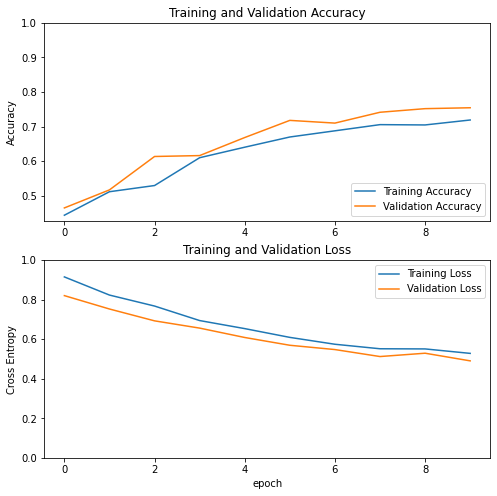

In [ ]:
#plotting the training & validation accuracy & loss using matplot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# **Fine Tuning**

In [ ]:
#Fine tuning the base model
base_model.trainable = True
# No. of layers in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [ ]:
#Re-compile the fine-tuned model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [ ]:
#Train the model again
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
35/35 [==============================] - 65s 2s/step - loss: 0.4224 - accuracy: 0.8032 - val_loss: 0.3983 - val_accuracy: 0.7650
Epoch 11/20
35/35 [==============================] - 60s 2s/step - loss: 0.3650 - accuracy: 0.8193 - val_loss: 0.3589 - val_accuracy: 0.8407
Epoch 12/20
35/35 [==============================] - 60s 2s/step - loss: 0.3328 - accuracy: 0.8515 - val_loss: 0.3681 - val_accuracy: 0.8460
Epoch 13/20
35/35 [==============================] - 60s 2s/step - loss: 0.3077 - accuracy: 0.8408 - val_loss: 0.3238 - val_accuracy: 0.8538
Epoch 14/20
35/35 [==============================] - 60s 2s/step - loss: 0.3030 - accuracy: 0.8685 - val_loss: 0.3357 - val_accuracy: 0.8512
Epoch 15/20
35/35 [==============================] - 60s 2s/step - loss: 0.2727 - accuracy: 0.8730 - val_loss: 0.3157 - val_accuracy: 0.8486
Epoch 16/20
35/35 [==============================] - 60s 2s/step - loss: 0.2480 - accuracy: 0.8864 - val_loss: 0.3318 - val_accuracy: 0.8747
Epoch 17/20
3

In [ ]:
#Adding all accuracy and loss values to an array
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

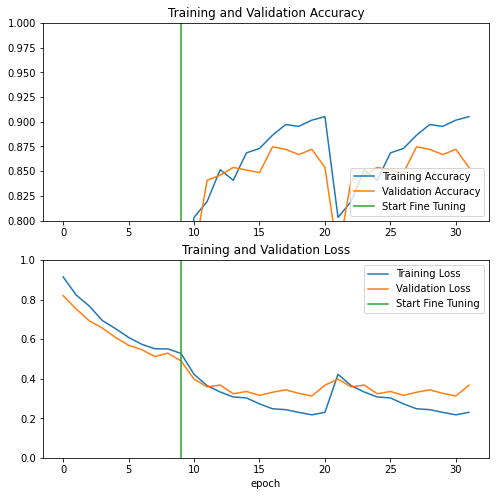

In [ ]:
#Plotting all accuracy and loss values using matplot
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# **Final Evaluation and Prediction**

In [ ]:
#Getting the final test accuracy
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

3/3 [==============================] - 9s 959ms/step - loss: 0.3914 - accuracy: 0.8854
Test accuracy : 0.8854166865348816


Predictions:
 [0 1 0 1 1 1 1 1 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1]
Labels:
 [0 1 0 1 1 0 1 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 0 0 0 0 1 1 0 0]


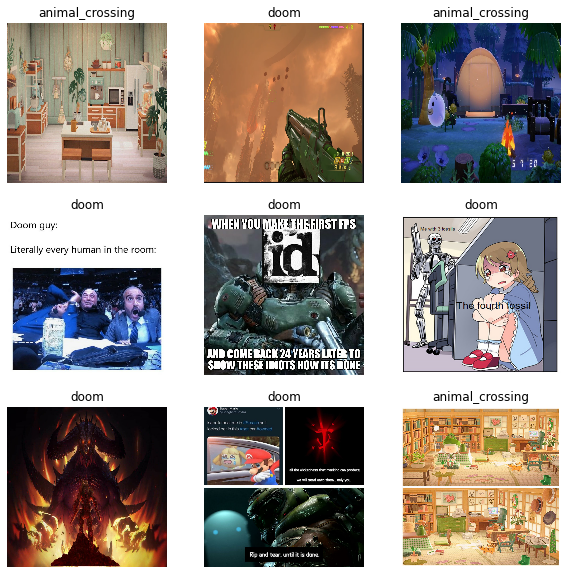

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")